# Exploring Seattle AirBnb Data : When, Where and Why? 

In [761]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
sns.set_style('white')

import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from datetime import datetime, timedelta

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings 
warnings.filterwarnings('ignore')

In [762]:
data_dir = './data/'

seattle_listings = pd.read_csv(data_dir + 'seattle/' + 'listings.csv')
seattle_calendar = pd.read_csv(data_dir + 'seattle/' + 'calendar.csv')

In [763]:
# For map visualizations later
seattle_coordinates = [47.6062, -122.3321]

# Preprocessing Functions

In [764]:
def parse_price(price):
    '''
    Price columns in the dataset is in the format of $XX.00, where XX indicates the value in dollars.
    This function will return the parsed value as float type
    
    Input
        price (str) - Price columns in the dataset is in the format of $XX.00
    Return
        parsed_price (float) - Parsed price as a float number, np.nan if input if error
    '''
    try:
        parsed_price = float(price.replace('.00', '').replace('$', ''))
        return parsed_price
    except Exception:
        return np.nan
    
def impute_with_mean_ratio(df, column, mean_ratio):
    '''
    Impute the weekly and monthly price columns using the mean ratio to the daily price.
    To be used with pandas.DataFrame.apply method
    
    Input
        df (pd.DataFrame) - DataFrame containing price_columns to be imputed.
        column - Column name to be imputed.
        mean_ratio - Mean ratio for non-missing entries.
    Return 
        imputed_value - If the data is missing, return imputed value (daily price * mean_ratio),
                        rounded to the nearest integer.
                        Otherwise, returns the original value in df.
    '''
    if pd.isnull(df[column]):
        imputed_value = round(mean_ratio * df['price'], 0)
        return imputed_value
    else:
        return df[column]

    
def create_df_with_price_bucket(neighborhood_df):
    '''
    This function modifies an input dataframe with an added column 'price_color'
    containing the information for plotting color based on the ranked average daily AirBnB rent price
    
    Bottom 25% Price Rank -> Green
    Middle 50% Price Rank -> Yellow
    Top 25% Price Rank -> Red
    
    Input
        neighborhood_df (pd.DataFrame) - neighborhood level DataFrame containing 
            the average price, latitude and longitude, and the count of listings
            in the neighborhood
    Return
        return_df (pd.DataFrame) - neighborhood_df with added 'price_color' 
            and 'price_category' column
    '''
    return_df = neighborhood_df.sort_values(by='price', ascending=True)
    
    color_bucket = ['' for _ in range(len(neighborhood_df))]
    
    category_bucket = ['' for _ in range(len(neighborhood_df))]
    
    lower_bound = round(0.25 * len(neighborhood_df), 0)
    upper_bound = round(0.75 * len(neighborhood_df), 0)
    
    lower_color = '#58D68D' # Green
    middle_color = '#F4D03F' # Yellow
    upper_color = '#EC7063' # Red
    
    for index in range(len(neighborhood_df)):
        if index <= lower_bound:
            color_bucket[index] = lower_color
            category_bucket[index] = 'Bottom 25%'
        elif index > lower_bound and index <= upper_bound:
            color_bucket[index] = middle_color
            category_bucket[index] = 'Middle 50%'
        else:
            color_bucket[index] = upper_color
            category_bucket[index] = 'Top 25%'
    
    return_df['price_color'] = color_bucket
    return_df['price_category'] = category_bucket
    
    return return_df


def create_map_price_visualizations(neighborhood_df_with_price_bucket, starting_location):
    '''
    This function generates a folium map object that visualizes the average daily rent price and 
    amount of listings across different Seattle neighborhoods.
    
    Size of bubble indicates the # of listings in the neighborhood (bigger -> more)
    Color of bubble indicates the relative rank of mean daily rent price of the neighborhood: 
        Green -> Price in bottom 25% 
        Yellow -> Price in middle 50% 
        Red -> Price in top 25%
    
    Input
        neighborhood_df_with_price_bucket (pd.DataFrame) - Output of create_df_with_price_bucket
    
    Return
        folium_map - a folium.Map object. Can be called to show the visualizations in jupyter notebook or
            can be saved into .html for embedding to other places
    '''
    
    folium_map = folium.Map(location = starting_location,
                        zoom_start = 11,
                        height = 800,
                        width = 500,
                        tiles = 'CartoDB positron')
    
    
    for index, row in neighborhood_df_with_price_bucket.iterrows():
        popup_text = "{}<br><br>Mean Daily Price: ${}<br><br>Listings: {}"
        popup_text = popup_text.format(
                          row['neighbourhood_cleansed'],
                          round(row['price'], 2),
                          row['listings_count']
                          )

        folium.CircleMarker(location=(row['latitude'],
                                      row['longitude']),
                            radius= row['listings_count']/30,
                            popup=popup_text,
                            weight=3,
                            color=row['price_color'],
                            fill=True).add_to(folium_map)
        
    return folium_map


def get_week(datestring):
    '''
    Returns the monday date of a particular week that datestring belongs to
    Example: For input of 2019-06-12, this function will return 2019-06-10
    
    Input
        datestring (str) - date in format of %Y-%m-%d
    Output
        weekstring (str) - Monday date in the week which day belongs to, 
            in same format as input
    '''
    
    dt = datetime.strptime(datestring, '%Y-%m-%d')
    num_days = dt.weekday()
    
    week_start = dt - timedelta(days=num_days)
    
    weekstring = datetime.strftime(week_start, '%Y-%m-%d')
    
    return weekstring


def transform_binary_categorical_features(df, binary_categorical_features, value_for_true):
    '''
    Transforms a binary categorical feature into 1 and 0 based on value_for_true.
    If entry == value_for_true, return 1
    
    Input
        df (pd.DataFrame) - DataFrame on which the transformation will be applied
        binary_categorical_features (list) - list of columns for to which the transformation will be applied
        value_for_true (any type) - value that means 'True', function will return 1 if entry is equal to this value
    Output 
        return_df (pd.DataFrame) - DataFrame on which the transformation has been carried on in binary_categorical_features columns
    '''
    
    return_df = df
    
    for col in binary_categorical_features:
        return_df[col] = return_df[col].apply(lambda x: 1 if x == value_for_true else 0)
        
    return return_df

In [765]:
price_columns = ['price', 'weekly_price', 'monthly_price',
                 'security_deposit', 'cleaning_fee', 'extra_people']

In [766]:
for price_column in price_columns:
    seattle_listings[price_column] = seattle_listings[price_column].apply(parse_price)

In [767]:
# Take the average for weekly/daily and monthly/daily price ratio to impute weekly and monthly price

weekly_price_ratio = seattle_listings[(pd.notnull(seattle_listings['price'])) &
                       (pd.notnull(seattle_listings['weekly_price']))]

mean_weekly_price_ratio = (weekly_price_ratio['weekly_price'] / weekly_price_ratio['price']).mean()


monthly_price_ratio = seattle_listings[(pd.notnull(seattle_listings['price'])) &
                       (pd.notnull(seattle_listings['monthly_price']))]

mean_monthly_price_ratio = (monthly_price_ratio['monthly_price'] / monthly_price_ratio['price']).mean()

In [768]:
seattle_listings['weekly_price'] = seattle_listings.apply(impute_with_mean_ratio, column = 'weekly_price', 
                              mean_ratio = mean_weekly_price_ratio, axis=1)

seattle_listings['monthly_price'] = seattle_listings.apply(impute_with_mean_ratio, column = 'monthly_price', 
                              mean_ratio = mean_monthly_price_ratio, axis=1)


# Normalize to price per person 
seattle_listings['price'] = seattle_listings['price'] / seattle_listings['accommodates']

# Neighbourhood Level Visualisation

This part of the notebook will analyze the price variation across neighborhoods in Seattle. 

The listings data will be aggregated to neighbourhood level, obtaining their average daily rent price and listings count. 

The neighbourhood data will then be visualised using a Folium map to help readers have a better understanding on: 

1. Where are the AirBnb listings located in Seattle
2. Where are the more expensive/cheaper areas in Seattle to stay

In [769]:
# Aggregate to neighbourhood level
neighbourhood_level = seattle_listings.groupby(['neighbourhood_cleansed']).agg({
    'price':'mean',
    'id':'count',
    'latitude':'mean',
    'longitude':'mean',
    'accommodates':'mean'
}).reset_index()

neighbourhood_level = neighbourhood_level.rename(columns={
    'id':'listings_count'
})

In [770]:
neighbourhood_level = create_df_with_price_bucket(neighbourhood_level)

neighbourhood_level = neighbourhood_level.sort_values(by='price', ascending=False)

In [771]:
# Display Top 5
display(neighbourhood_level.head(5))
# Display Bottom 5
display(neighbourhood_level.tail(5))

,neighbourhood_cleansed,price,listings_count,latitude,longitude,accommodates,price_color,price_category
72,South Lake Union,89.796331,134,47.622100,-122.335751,2.925373,#EC7063,Top 25%
12,Central Business District,83.590739,222,47.608682,-122.336110,3.734234,#EC7063,Top 25%
4,Belltown,64.047153,503,47.615109,-122.346163,3.473161,#EC7063,Top 25%
58,Pike-Market,63.354545,193,47.609781,-122.341231,3.808290,#EC7063,Top 25%
84,Westlake,60.701380,113,47.632077,-122.341584,2.690265,#EC7063,Top 25%


,neighbourhood_cleansed,price,listings_count,latitude,longitude,accommodates,price_color,price_category
59,Pinehurst,26.678649,32,47.716828,-122.319525,3.750000,#58D68D,Bottom 25%
71,South Delridge,26.468496,41,47.525661,-122.359562,3.682927,#58D68D,Bottom 25%
7,Brighton,25.668067,51,47.539923,-122.277080,3.843137,#58D68D,Bottom 25%
70,South Beacon Hill,24.901351,37,47.527667,-122.286895,3.783784,#58D68D,Bottom 25%
65,Riverview,24.823659,48,47.543866,-122.355240,3.958333,#58D68D,Bottom 25%


In [772]:
neighbourhood_level.to_csv('neighbourhood_data.csv', index=False)

In [773]:
# Create Folium Map
seattle_map = create_map_price_visualizations(neighbourhood_level, starting_location=seattle_coordinates)

In [774]:
seattle_map.save('seattle_listings_map.html')
seattle_map

# Analysing Weekly Price Trend Across Areas

This part of the notebook will help readers to understand better how rent prices of AirBnb listings in Seattle changes with time of year. 

It will also help to answer the hypothesis that different areas might have different price trends with respect to time. 

In doing so, the steps are : 

1. Joining data in seattle_calendar to give every listing an identifier of which price bucket does it belong to
2. Generate a week column (Monday based) for every date
3. Group by neighborhood type and week level to find the average price
4. Visualise the price vs time (week) for different neighbourhood categories to better understand the trend

In [775]:
# Get the price bucket for every listing (based on neighbourhood_level dataframe)
listings_with_price_categories = seattle_listings\
    .merge(neighbourhood_level[['neighbourhood_cleansed', 'price_category', 'price_color']], 
                                                        on=['neighbourhood_cleansed'])

listings_to_join_with_calendar = listings_with_price_categories[['id', 'price_category', 'price_color']]

listings_to_join_with_calendar = listings_to_join_with_calendar.rename(columns={
    'id':'listing_id'
})

In [776]:
# Join time data with listings data that is equipped with price bucket information
calendar_df = seattle_calendar.merge(listings_to_join_with_calendar, on=['listing_id'])

In [777]:
# Parse the price and get the week of every entry
calendar_df['price'] = calendar_df['price'].apply(parse_price)
calendar_df['week'] = calendar_df['date'].apply(get_week)

In [778]:
# Get the mean price per group
week_df = calendar_df.groupby(['week', 'price_category', 'price_color']).agg({
    'price':'mean'
}).reset_index()
# Filter out to entries in 2019 only
week_df = week_df[week_df['week'] < '2020-01-01']

<Figure size 432x288 with 0 Axes>

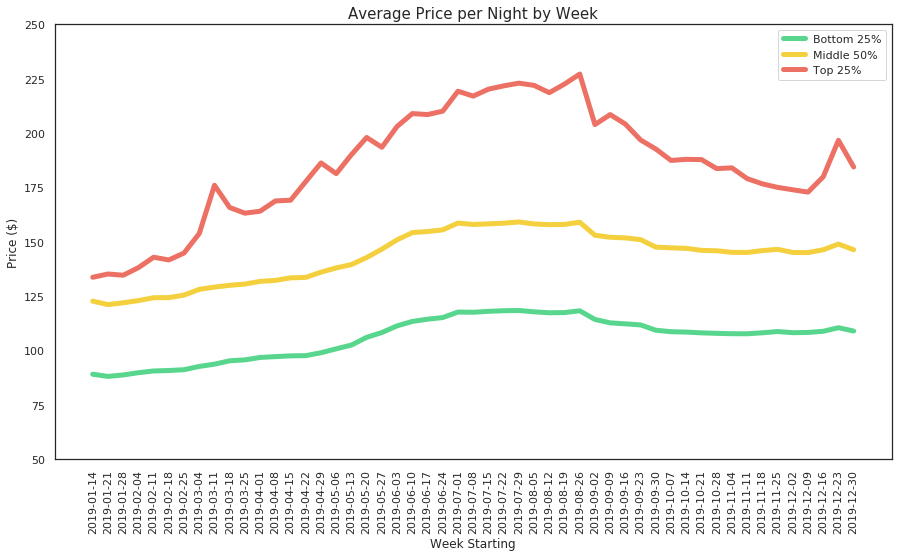

In [779]:
# Plot the weekly price vs Time 
plt.figure()
plt.figure(figsize=(15,8))
for index, row in week_df[['price_category', 'price_color']].drop_duplicates().iterrows():
    price_df = week_df[week_df['price_category'] == row['price_category']]
    sns.lineplot(x='week', y='price', color=row['price_color'], data=price_df, linewidth=5, label=row['price_category'])
plt.title('Average Price per Night by Week', fontsize=15)
plt.ylabel('Price ($)')
plt.xlabel('Week Starting')
plt.ylim(50, 250)
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Predicting Price Category

This part of the notebook will attempt to predict whether a particular listing falls into the top 25% price category using features other than neighbourhood.

Steps involved: 

1. Taking a subset of columns separated into numerical features, categorical features and target variable
2. Performing one-hot encoding on the categorical features
3. Splitting the data to train and test set
4. Building a machine learning pipeline that imputes, scale, and finally train a model based on the data
5. Get the top 5 features of the classifier predicting the top 25% class and visualise them across different classes to interpret the method

In [780]:
numerical_features = [
    'number_of_reviews',
    'bathrooms', 
    'beds',
    'security_deposit',
    'cleaning_fee',
    'extra_people',
    'minimum_nights'
]

binary_categorical_features = [
    'is_business_travel_ready',
    'require_guest_profile_picture',
    'require_guest_phone_verification'
]

categorical_features = [
    'property_type',
    'room_type',
    'cancellation_policy'
]

target_variable = [
    'price_category'
]

In [781]:
# Take subset of columns
predict_df = df.merge(listings_with_price_categories[['id', 'price_category', 'price_color']], on=['id'])
predict_df = predict_df[numerical_features + binary_categorical_features + categorical_features + target_variable]

In [782]:
# Process binary categorical features
predict_df = transform_binary_categorical_features(predict_df, binary_categorical_features, 't')

In [783]:
# Process categorical_features
categorical_dummies = pd.get_dummies(predict_df[categorical_features])
predict_df = predict_df.join(categorical_dummies)
# Drop original categorical columns
predict_df = predict_df.drop(categorical_features, axis=1)

In [784]:
X = predict_df[[col for col in predict_df.columns if col not in target_variable]]
y = predict_df[target_variable]

In [785]:
# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [786]:
# Build a Logistic Regression pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

In [787]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [788]:
# Predict Test Data
preds = pipeline.predict(X_test)

In [789]:
# Evaluate model performance on the testing set
clf = pipeline.steps[2][1]
features = X_train.columns

price_confusion_matrix = confusion_matrix(y_test, preds)
price_confusion_matrix = pd.DataFrame(price_confusion_matrix, index=clf.classes_, columns=clf.classes_)

price_confusion_matrix

,Bottom 25%,Middle 50%,Top 25%
Bottom 25%,2,198,35
Middle 50%,0,612,202
Top 25%,0,154,494


Based on the confusion matrix above, it can be seen that the model is a really poor predictor for the bottom 25% class, but predicts the top 25% well. 

As we are answering the question of how the expensive listings are different than the rest, we will then take the classifier predicting the top 25% class, sort the features based on the score coefficients, and take the top 5

In [790]:
# Get the 5 features with highest Logit coefficient
important_features_dict = {
    clf.classes_[index]:features[np.argsort(-clf.coef_[index])][:5].tolist() for index,feature in enumerate(clf.classes_)
}

In [791]:
for key, val in important_features_dict.items():
    print('Top 5 Features in predicting {} are :'.format(key), val)
    print('\n')

Top 5 Features in predicting Bottom 25% are : ['property_type_House', 'property_type_Townhouse', 'beds', 'property_type_Guesthouse', 'property_type_Guest suite']


Top 5 Features in predicting Middle 50% are : ['property_type_House', 'cancellation_policy_moderate', 'property_type_Guest suite', 'cancellation_policy_flexible', 'property_type_Townhouse']


Top 5 Features in predicting Top 25% are : ['cancellation_policy_strict', 'property_type_Serviced apartment', 'property_type_Apartment', 'property_type_Condominium', 'cleaning_fee']




In [792]:
# Get the top 5 features for predicting the Top 25% Class
top_25_price_features = important_features_dict['Top 25%']
viz_df = predict_df[top_25_price_features + ['price_category']].dropna()

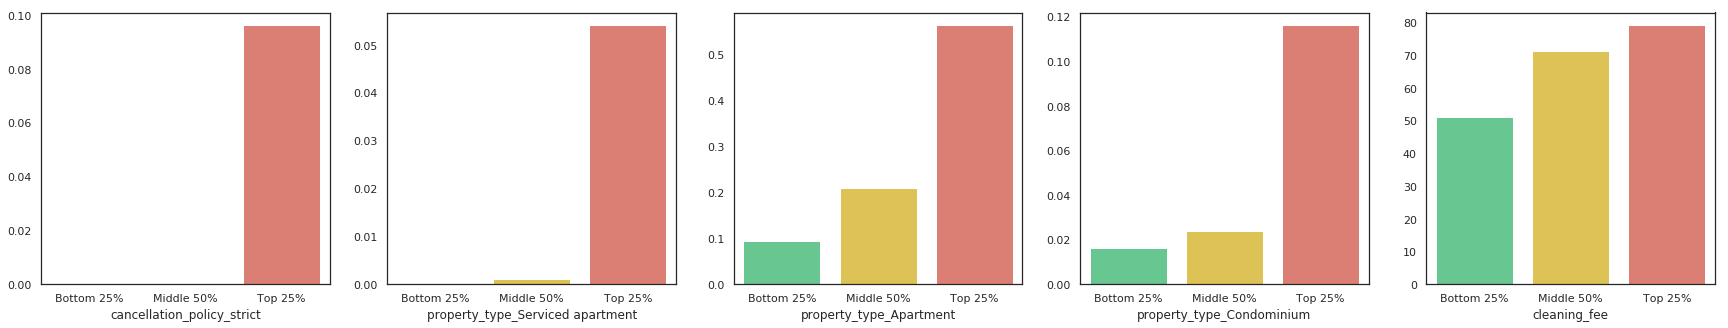

In [793]:
# Visualize the top 5 features across different classes
fig, axs = plt.subplots(1,len(top_25_price_features))
fig.set_size_inches(30,5)
for index, feat in enumerate(top_25_price_features):
    mean_df = viz_df.groupby(['price_category'])[feat].mean().reset_index()
    sns.barplot(x='price_category', y=feat, data=mean_df, palette=['#58D68D','#F4D03F','#EC7063'], ax=axs[index])
    axs[index].set_xlabel(feat)
    axs[index].set_ylabel('')
plt.show()